In [1]:
import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [8]:
epoch = 20
batch_size = 1024
learning_rate = 0.0002
num_gpus = 1

In [20]:
# Download Data
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("./", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [11]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [13]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

In [14]:

# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    fig, axes = plt.subplots(1, 2)
    
    for i in range(2):    
        axes[i].imshow(img[i][0],cmap='gray')
    plt.show()

0th iteration gen_loss: 0.13456179201602936 dis_loss: 0.9099700450897217
0th iteration gen_loss: 0.5212475061416626 dis_loss: 0.23047223687171936


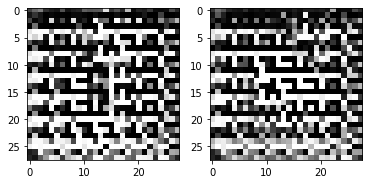

1th iteration gen_loss: 0.5445787906646729 dis_loss: 0.2257813811302185
1th iteration gen_loss: 0.3282436728477478 dis_loss: 0.5338181257247925


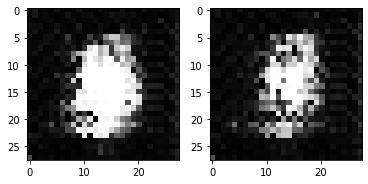

2th iteration gen_loss: 0.3101019263267517 dis_loss: 0.4887200593948364
2th iteration gen_loss: 0.27533572912216187 dis_loss: 0.5168254375457764


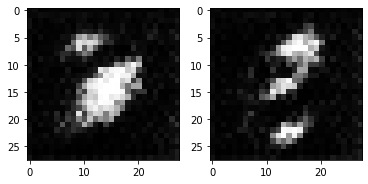

3th iteration gen_loss: 0.2696371078491211 dis_loss: 0.5528308153152466
3th iteration gen_loss: 0.2840830981731415 dis_loss: 0.5127665400505066


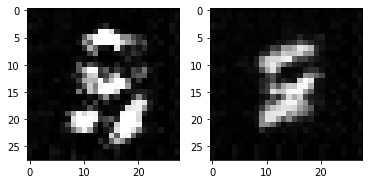

4th iteration gen_loss: 0.260276198387146 dis_loss: 0.5257517099380493
4th iteration gen_loss: 0.28793737292289734 dis_loss: 0.5014745593070984


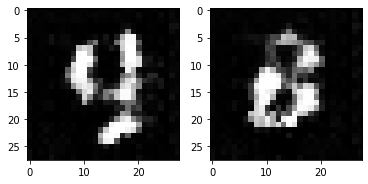

5th iteration gen_loss: 0.287267804145813 dis_loss: 0.48916926980018616
5th iteration gen_loss: 0.28441157937049866 dis_loss: 0.47394442558288574


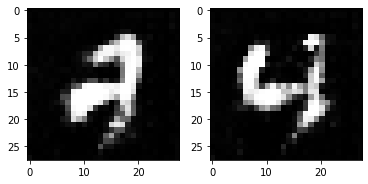

6th iteration gen_loss: 0.3015857934951782 dis_loss: 0.45841535925865173
6th iteration gen_loss: 0.2699677348136902 dis_loss: 0.4883044362068176


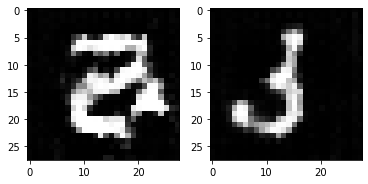

7th iteration gen_loss: 0.2723594605922699 dis_loss: 0.49396800994873047
7th iteration gen_loss: 0.26977652311325073 dis_loss: 0.49743908643722534


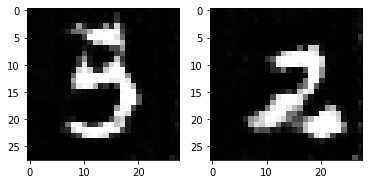

8th iteration gen_loss: 0.2811610698699951 dis_loss: 0.4729958474636078
8th iteration gen_loss: 0.26989805698394775 dis_loss: 0.4956376850605011


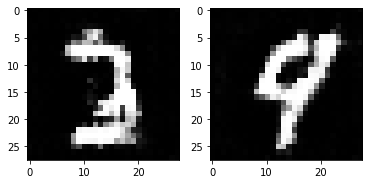

9th iteration gen_loss: 0.2864697277545929 dis_loss: 0.4895611107349396
9th iteration gen_loss: 0.25501811504364014 dis_loss: 0.4870937466621399


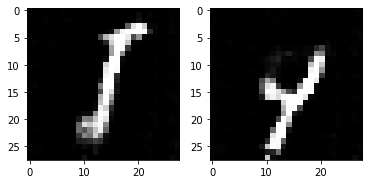

10th iteration gen_loss: 0.25996193289756775 dis_loss: 0.5036563873291016
10th iteration gen_loss: 0.2628573477268219 dis_loss: 0.4966498613357544


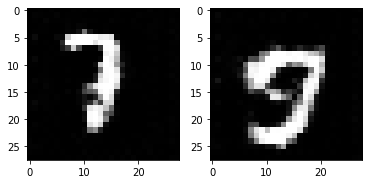

11th iteration gen_loss: 0.25604987144470215 dis_loss: 0.5095633864402771
11th iteration gen_loss: 0.26288414001464844 dis_loss: 0.5058629512786865


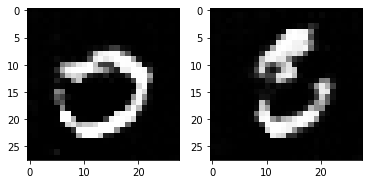

12th iteration gen_loss: 0.27536019682884216 dis_loss: 0.5038903951644897
12th iteration gen_loss: 0.26278600096702576 dis_loss: 0.49971672892570496


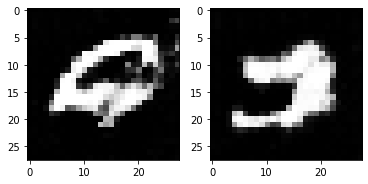

13th iteration gen_loss: 0.250573068857193 dis_loss: 0.5010187029838562
13th iteration gen_loss: 0.24692413210868835 dis_loss: 0.5043349266052246


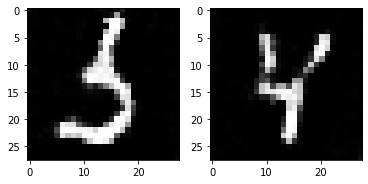

14th iteration gen_loss: 0.24822421371936798 dis_loss: 0.5000585913658142
14th iteration gen_loss: 0.2634018659591675 dis_loss: 0.4966026842594147


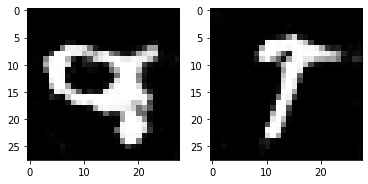

15th iteration gen_loss: 0.2566101551055908 dis_loss: 0.49867522716522217
15th iteration gen_loss: 0.2573823928833008 dis_loss: 0.49368613958358765


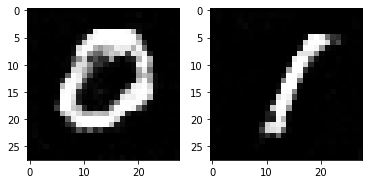

16th iteration gen_loss: 0.25492995977401733 dis_loss: 0.49882441759109497
16th iteration gen_loss: 0.2567393183708191 dis_loss: 0.4980841875076294


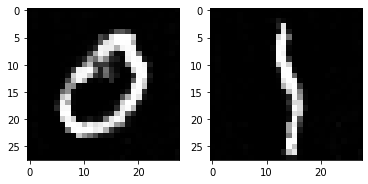

17th iteration gen_loss: 0.26445889472961426 dis_loss: 0.5021511912345886
17th iteration gen_loss: 0.2653443515300751 dis_loss: 0.4988468587398529


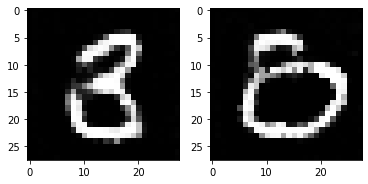

18th iteration gen_loss: 0.25093787908554077 dis_loss: 0.500718355178833
18th iteration gen_loss: 0.2560077905654907 dis_loss: 0.4955541491508484


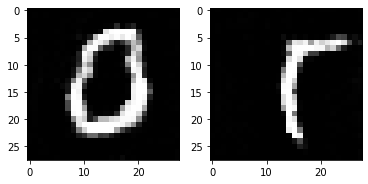

19th iteration gen_loss: 0.25252285599708557 dis_loss: 0.4977918565273285
19th iteration gen_loss: 0.2602411210536957 dis_loss: 0.49373698234558105


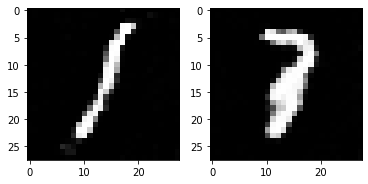

In [16]:
for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            #print(gen_loss,dis_loss)
            torch.save(generator.state_dict(),'./saved_model/generator.pkl')
            torch.save(discriminator.state_dict(),'./saved_model/discriminator.pkl')


            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())

In [17]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z,Lambda=0.1):
    _,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z))
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

start_idx = 64
test_size = 8

test_data_mnist = mnist_test.__dict__['data'][start_idx:start_idx+test_size]
test_data_mnist = test_data_mnist.view(test_size,1,28,28).type_as(torch.FloatTensor())
test_data_mnist.size()

torch.Size([8, 1, 28, 28])

In [24]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))

    print("\n--------model restored--------\n")

except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [25]:
z = Variable(init.normal(torch.zeros(test_size,100),mean=0,std=0.1),requires_grad=True)
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(test_data_mnist).cuda(),gen_fake)
print(loss)

tensor(203848.8438, device='cuda:0', grad_fn=<AddBackward0>)


In [28]:
for i in range(50000):
    gen_fake = generator(z.cuda())
    loss = Anomaly_score(Variable(test_data_mnist).cuda(),gen_fake,Lambda=0.01)
    loss.backward()
    z_optimizer.step()
    
    if i%100==0:
        print(loss.cpu().data)
        '''
        target = test_data_mnist[1,0,:,:].numpy()
        plt.imshow(target,cmap="gray")
        plt.show()
        
        img=gen_fake.cpu().data[1,0,:,:].numpy()
        plt.imshow(img,cmap='gray')
        plt.show()
        '''

tensor(222101.4375)
tensor(222097.6719)
tensor(222096.5781)
tensor(222093.6875)
tensor(222091.4844)
tensor(222088.7500)
tensor(222086.0312)
tensor(222084.1875)
tensor(222080.7656)
tensor(222077.7969)
tensor(222076.5469)
tensor(222073.5469)
tensor(222073.6406)
tensor(222070.9219)
tensor(222068.7656)
tensor(222067.5938)
tensor(222063.2500)
tensor(222062.7031)
tensor(222061.2031)
tensor(222057.5781)
tensor(222057.9531)
tensor(222056.4844)
tensor(222054.2500)
tensor(222054.6250)
tensor(222052.3438)
tensor(222048.6719)
tensor(222048.8125)
tensor(222047.4531)
tensor(222044.3594)
tensor(222041.5469)
tensor(222040.9844)
tensor(222039.2656)
tensor(222035.1406)
tensor(222034.1562)
tensor(222033.9375)
tensor(222031.6875)
tensor(222029.1719)
tensor(222027.7656)
tensor(222027.7344)
tensor(222024.9219)
tensor(222022.)
tensor(222021.6562)
tensor(222021.6250)
tensor(222020.0156)
tensor(222017.3594)
tensor(222015.3125)
tensor(222014.9844)
tensor(222014.4062)
tensor(222012.3438)
tensor(222010.2188)
tens

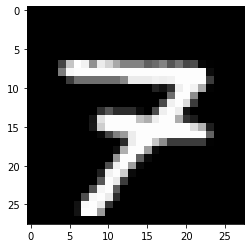

real data


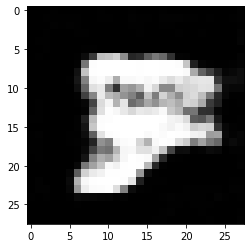

generated data

------------------------------------



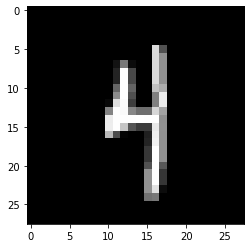

real data


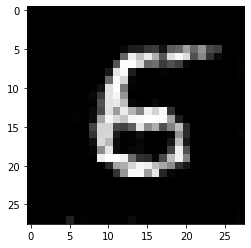

generated data

------------------------------------



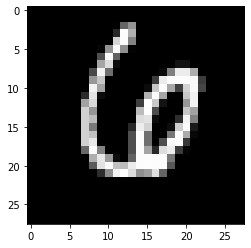

real data


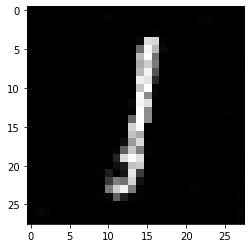

generated data

------------------------------------



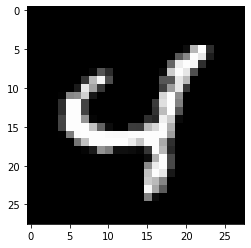

real data


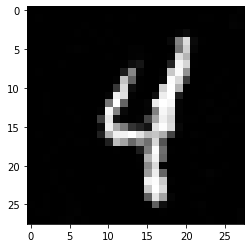

generated data

------------------------------------



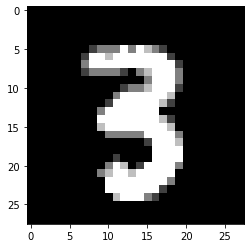

real data


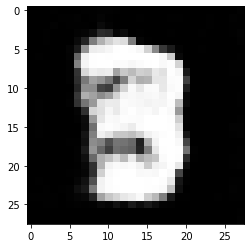

generated data

------------------------------------



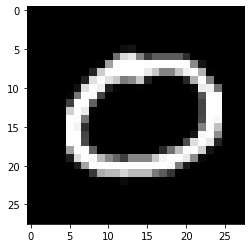

real data


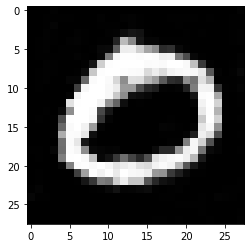

generated data

------------------------------------



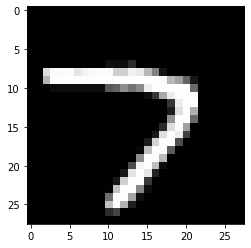

real data


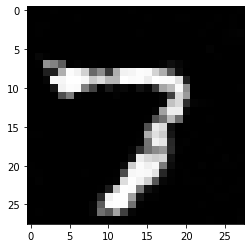

generated data

------------------------------------



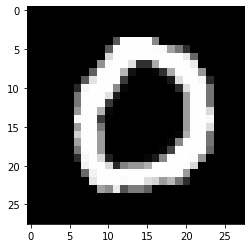

real data


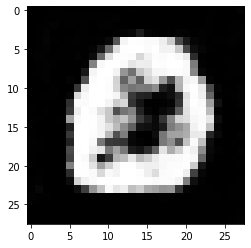

generated data

------------------------------------



In [27]:
for idx in range(test_size):
    target = test_data_mnist[idx,0,:,:].numpy()
    plt.imshow(target,cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:].numpy()
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")